# IDS Integrated Data Asset (IDA) Linkage demo

This script is broadly intended to demonstrate how easily RDMF indexed IDAs can be linked and thus prepared for analysts to use.

In [203]:
# import needed packages (not many!)
from google.cloud import bigquery
import pandas as pd

In [204]:
# initiate client for bigquery
client = bigquery.Client(location="europe-west2")

## Joining std and georef files
First, we need to link together the `std` and `georef` versions of the LRPP data asset, so that we have all of the data's attributes, along with it's address information that will link back to the Address Index. These each have `guid` columns this can be done with.

First, let's do this for the Land Registry Price Paid (LRPP) data, which will give us house sale price information:

In [47]:
# joining georef and std LRPP tables
query = ("""

SELECT
  *
FROM
  `ingest_ida_land_registry_price_paid.prices_paid_georef` t1
JOIN
  `ingest_ida_land_registry_price_paid.prices_paid_std` t2
ON
  t1.id = t2.guid

""")
table_ref = 'ons-ids-analysis-prod.demo_wip_notebook.lrpp_linked'

job_config = bigquery.QueryJobConfig(
    destination= table_ref
)

query_job = client.query(
    query,
    location="europe-west2",
    job_config=job_config
)

query_job.result()

## Linking the EPC, LRPP and OSPOS data
Next, and this is the bit where the Integrated Data Asset version of these datasets comes in handy, we can link all of these sources together on their `address_entry_id` variables. This is the lookup to the RDMF, specifically the address index, and is a unique identifier in this case.

In [103]:
# joining OSPOS and (newly joined) LRPP tables
query = ("""

SELECT
  geography_entry_id_lsoa_code,
  geography_entry_id_oa_code,
  geography_entry_id_lad_code,
  geography_entry_id_msoa_code,
  geography_entry_id_country_code,
  geography_entry_id_region_code,
  lsoa_code_hashed,
  oa_code_hashed,
  lad_code_hashed,
  msoa_code_hashed,
  country_code_hashed,
  region_code_hashed,
  class,
  voa_ct_record,
  ruc_code,
  ruc,
  ur2fold,
  ur3fold,
  ur6fold,
  ur8fold,
  building_flat_count,
  private_outdoor_space,
  private_outdoor_space_area,
  t1.address_entry_id_uprn,
  t2.address_entry_id_uprn AS t2_address_entry_id_uprn,
  t2.id,
  apiversion,
  confidencescore,
  epoch,
  underlyingscore,
  t2.geography_entry_id_postcode,
  t2.postcode_hashed,
  t2.guid,
  t2.transaction_uid,
  price,
  date_of_transfer,
  t2.property_type,
  old_new,
  duration,
  locality,
  ppd_category_type,
  derived_year
FROM
  `ons-ids-data-prod.ingest_ida_ordnance_survey_private_outside_space.april_gb_private_outdoor_space_std` AS t1
JOIN
  `ons-ids-analysis-prod.demo_wip_notebook.lrpp_linked` AS t2
ON
  t1.address_entry_id_uprn = t2.address_entry_id_uprn
JOIN
  `ons-ids-data-prod.ingest_ida_epc.all_domestic_certificates_202203_std` AS t3
ON
  t3.address_entry_id_uprn = t2.address_entry_id_uprn
  
""")

table_ref = 'ons-ids-analysis-prod.demo_wip_notebook.ospos_lrpp_linked'

job_config = bigquery.QueryJobConfig(
    destination= table_ref
)

job_config.write_disposition = "WRITE_TRUNCATE"

query_job = client.query(
    query,
    location="europe-west2",
    job_config=job_config
)

query_job.result()

## Non-matches and bias

For cases where records did not match to an RDMF index, for example the Address Index, their `address_entry_id` will be null. This allows easy identification of the non-matching records.

Let's explore this for our OSPOS (Private Outside Space) data:

In [358]:
# read in OSPOS for region lookup to ospos non-links
query = ("""
SELECT 

 address_entry_id_uprn,
 geography_entry_id_region_code
FROM
  `ons-ids-data-prod.ingest_ida_ordnance_survey_private_outside_space.april_gb_private_outdoor_space_std`
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

ospos = query_job.to_dataframe()

In [359]:
# read in geography index lookup to obtain geographic data for bias analysis
query = ("""
SELECT 
 *
FROM
  `ons-ids-analysis-prod.demo_wip_notebook.geography_index_lookup`
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

gi = query_job.to_dataframe()

In [360]:
# join geography index to ospos
ospos = pd.merge(ospos, gi, on = 'geography_entry_id_region_code', how = 'left')

In [387]:
# create linked dataframe
links = ospos[ospos['address_entry_id_uprn'].isnull()==False]['region_name'].value_counts().to_frame()

links.columns = ['linked_count']
links.index.names = ['region']

In [388]:
# create non-linked dataframe
non_links = ospos[ospos['address_entry_id_uprn'].isnull()==True]['region_name'].value_counts().to_frame()

non_links.columns = ['non_linked_count']
non_links.index.names = ['region']

In [389]:
# merge linked and non-linked dataframes for output
df = pd.merge(links, non_links, on = 'region', how = 'inner')

# calculate proportion of IDA data that has linked
df['links'] = df['linked_count']/df['linked_count'].sum()*100

# calculate proportion of data that has not linked
df['non-links'] = df['non_linked_count']/df['non_linked_count'].sum()*100

Overall match rate can then be easily calculated:

In [366]:
unmatched  = df['non_linked_count'].sum()
matched  = df['linked_count'].sum()

print("the match rate is:", ((matched-unmatched)/matched)*100)

the match rate is: 99.98776132810218


And we can take this further by then easily exploring the characteristics of the linked and non-linked data. For instance, exploring the trends in matches vs non-matches by region:

In [391]:
df

,linked_count,non_linked_count,links,non-links
region,,,,
South East,3975090,199,16.079,6.576
London,3705372,187,14.988,6.180
North West,3351279,857,13.556,28.321
East of England,2723140,583,11.015,19.266
South West,2604346,367,10.535,12.128
West Midlands,2538132,250,10.267,8.262
Yorkshire and The Humber,2453069,322,9.923,10.641
East Midlands,2122978,257,8.587,8.493
North East,1248473,4,5.050,0.132


Text(0.5, 0, 'percentage')

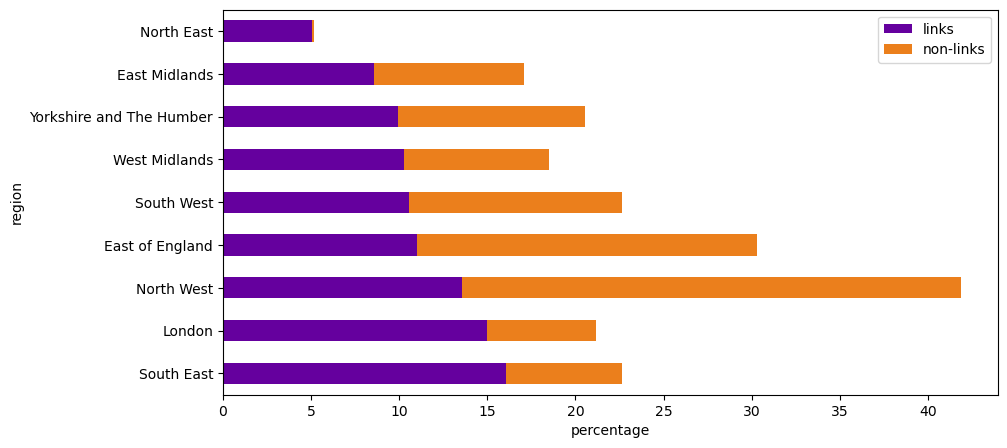

In [393]:
ax = df[['links','non-links']].plot.barh(figsize=(10,5),
                                         stacked = True, 
                                         color = {"links": "#65009E",
                                                  "non-links": "#EB7F1C"})
ax.set_xlabel("percentage")

Here we have only explored regional bias in our linked data, but other attributes and their associated bias can be just as easily analysed through these assets' integration with Address and Geography Indexes.